Epoch 0, Loss: 269.646423, IC Loss: 23.253607
Epoch 400, Loss: 21.927271, IC Loss: 0.000942
Epoch 800, Loss: 21.801439, IC Loss: 0.000194
Epoch 1200, Loss: 21.771313, IC Loss: 0.000107
Epoch 1600, Loss: 21.703442, IC Loss: 0.000101
Epoch 2000, Loss: 21.408827, IC Loss: 0.000042
Epoch 2400, Loss: 21.122988, IC Loss: 0.000015
Epoch 2800, Loss: 20.913816, IC Loss: 0.000009
Epoch 3200, Loss: 20.670851, IC Loss: 0.000002
Epoch 3600, Loss: 20.436497, IC Loss: 0.000002
Epoch 4000, Loss: 20.278170, IC Loss: 0.000003
Epoch 4400, Loss: 20.157179, IC Loss: 0.000278
Epoch 4800, Loss: 19.992750, IC Loss: 0.000000
Epoch 5200, Loss: 19.780382, IC Loss: 0.000000
Epoch 5600, Loss: 19.517355, IC Loss: 0.000000
Epoch 6000, Loss: 18.964634, IC Loss: 0.000001
Epoch 6400, Loss: 18.211044, IC Loss: 0.000000
Epoch 6800, Loss: 17.309605, IC Loss: 0.000001
Epoch 7200, Loss: 16.618069, IC Loss: 0.000000
Epoch 7600, Loss: 15.864655, IC Loss: 0.000003
Epoch 8000, Loss: 15.069181, IC Loss: 0.000000
Epoch 8400, Loss

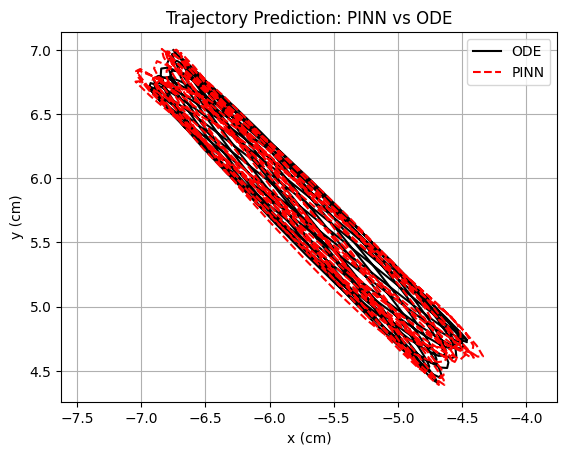

In [ ]:
# Physics-Informed Neural Network (PINN) with IC enforcement for Ball Dynamics
# Updated for Colab with working PyTorch

import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp

# Device setup
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Parameters
params = {
    'alpha': 0.07, 'beta': 1.017, 'gamma': 15.103, 'delta': 0.00656,
    'H0': 12.065, 'g': 981, 'c': 0.0025, 'm': 0.1, 'inertia': 7/5
}

# Ball dynamics
def ball_dynamics(t, y, p):
    x, y_, dx, dy = y
    alpha, beta, gamma, delta = p['alpha'], p['beta'], p['gamma'], p['delta']
    g, c, m, I = p['g'], p['c'], p['m'], p['inertia']
    eps = 1e-6
    Hx = 2*alpha*x - beta*x/np.sqrt(x**2 + gamma + eps) - delta*y_
    Hy = 2*alpha*y_ - beta*y_/np.sqrt(y_**2 + gamma + eps) - delta*x
    Hxx = 2*alpha - beta*gamma/(x**2 + gamma + eps)**1.5
    Hyy = 2*alpha - beta*gamma/(y_**2 + gamma + eps)**1.5
    Hxy = -delta
    M = I * np.array([[1+Hx**2, Hx*Hy], [Hx*Hy, 1+Hy**2]])
    F = np.array([
        -I*(Hxx*(Hx*dx**2 + Hy*dx*dy) + Hxy*(Hx*dx*dy + Hy*dy**2)) - (c/m)*((1+Hx**2)*dx + Hx*Hy*dy) - Hx*g,
        -I*(Hyy*(Hy*dy**2 + Hx*dx*dy) + Hxy*(Hy*dx*dy + Hx*dx**2)) - (c/m)*((1+Hy**2)*dy + Hx*Hy*dx) - Hy*g
    ])
    acc = np.linalg.solve(M, F)
    return [dx, dy, acc[0], acc[1]]

# Trajectory generator
def generate_trajectory(p, y0, t_eval):
    sol = solve_ivp(lambda t, y: ball_dynamics(t, y, p), [t_eval[0], t_eval[-1]], y0, t_eval=t_eval)
    return sol.y.T

# PINN model
class SimplePINN(nn.Module):
    def __init__(self):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(5, 64), nn.Tanh(),
            nn.Linear(64, 64), nn.Tanh(),
            nn.Linear(64, 4)
        )

    def forward(self, t, ic):
        ic_repeated = ic.repeat(t.shape[0], 1)
        inp = torch.cat([t, ic_repeated], dim=1)
        return self.net(inp)

# Physics residuals (dummy for now)
def physics_residuals(x, y, dx, dy, ddx, ddy, p):
    return torch.zeros_like(x)  # placeholder

# Data setup
t_np = np.linspace(0, 10, 300)
y0 = [-6.75, 7.0, 0.0, 0.0]
y_np = generate_trajectory(params, y0, t_np)

# Tensors
t_tensor = torch.tensor(t_np, dtype=torch.float32).view(-1, 1).to(device)
y_tensor = torch.tensor(y_np, dtype=torch.float32).to(device)
ic_tensor = torch.tensor([y0], dtype=torch.float32).to(device)

# Model + optimizer
model = SimplePINN().to(device)
optimizer = optim.Adam(model.parameters(), lr=1e-3)

# Training loop with IC enforcement
t0_tensor = torch.tensor([[0.0]], dtype=torch.float32).to(device)
for epoch in range(40000):
    optimizer.zero_grad()
    pred = model(t_tensor, ic_tensor)
    loss_data = torch.mean((pred - y_tensor)**2)

    # Enforce IC match
    pred_ic = model(t0_tensor, ic_tensor)
    loss_ic = torch.mean((pred_ic - ic_tensor)**2)

    loss = loss_data + 10.0 * loss_ic
    loss.backward()
    optimizer.step()

    if epoch % 400 == 0:
        print(f"Epoch {epoch}, Loss: {loss.item():.6f}, IC Loss: {loss_ic.item():.6f}")

# Prediction
t_test = torch.tensor(np.linspace(0, 10, 400), dtype=torch.float32).view(-1, 1).to(device)
with torch.no_grad():
    pred = model(t_test, ic_tensor).cpu().numpy()

true = generate_trajectory(params, y0, np.linspace(0, 10, 400))

plt.plot(true[:, 0], true[:, 1], 'k-', label='ODE')
plt.plot(pred[:, 0], pred[:, 1], 'r--', label='PINN')
plt.axis('equal')
plt.xlabel("x (cm)")
plt.ylabel("y (cm)")
plt.title("Trajectory Prediction: PINN vs ODE")
plt.legend()
plt.grid(True)
plt.show()


Epoch 0, Loss: 824.907288, IC Loss: 44.540321
Epoch 400, Loss: 377.628510, IC Loss: 0.012434
Epoch 800, Loss: 369.542145, IC Loss: 0.006418
Epoch 1200, Loss: 354.457367, IC Loss: 0.002800
Epoch 1600, Loss: 334.765961, IC Loss: 0.003770
Epoch 2000, Loss: 302.432526, IC Loss: 0.000387
Epoch 2400, Loss: 275.763031, IC Loss: 0.000155
Epoch 2800, Loss: 247.426926, IC Loss: 0.000188
Epoch 3200, Loss: 223.376221, IC Loss: 0.000126
Epoch 3600, Loss: 208.837265, IC Loss: 0.000105
Epoch 4000, Loss: 199.410614, IC Loss: 0.000035
Epoch 4400, Loss: 189.066071, IC Loss: 0.000046
Epoch 4800, Loss: 164.546982, IC Loss: 0.000017
Epoch 5200, Loss: 153.658829, IC Loss: 0.000041
Epoch 5600, Loss: 146.922318, IC Loss: 0.000021
Epoch 6000, Loss: 131.215942, IC Loss: 0.000136
Epoch 6400, Loss: 107.902451, IC Loss: 0.000007
Epoch 6800, Loss: 95.670158, IC Loss: 0.000562
Epoch 7200, Loss: 90.677498, IC Loss: 0.000006
Epoch 7600, Loss: 86.941498, IC Loss: 0.000005
Epoch 8000, Loss: 84.733627, IC Loss: 0.000014


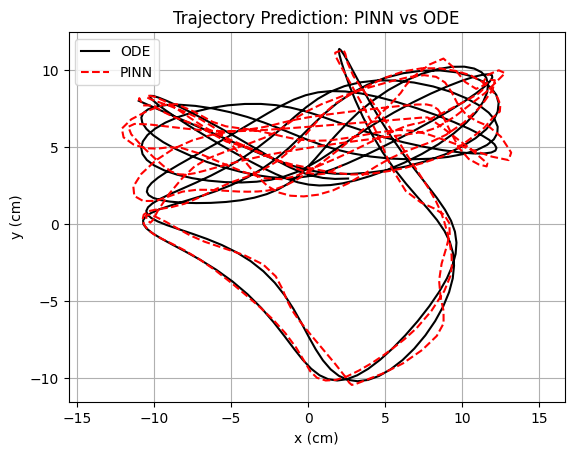

In [ ]:
# Physics-Informed Neural Network (PINN) with IC enforcement for Ball Dynamics
# Updated for Colab with working PyTorch

import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp

# Device setup
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Parameters
params = {
    'alpha': 0.07, 'beta': 1.017, 'gamma': 15.103, 'delta': 0.00656,
    'H0': 12.065, 'g': 981, 'c': 0.0025, 'm': 0.1, 'inertia': 7/5
}

# Ball dynamics
def ball_dynamics(t, y, p):
    x, y_, dx, dy = y
    alpha, beta, gamma, delta = p['alpha'], p['beta'], p['gamma'], p['delta']
    g, c, m, I = p['g'], p['c'], p['m'], p['inertia']
    eps = 1e-8
    Hx = 2*alpha*x - beta*x/np.sqrt(x**2 + gamma + eps) - delta*y_
    Hy = 2*alpha*y_ - beta*y_/np.sqrt(y_**2 + gamma + eps) - delta*x
    Hxx = 2*alpha - beta*gamma/(x**2 + gamma + eps)**1.5
    Hyy = 2*alpha - beta*gamma/(y_**2 + gamma + eps)**1.5
    Hxy = -delta
    M = I * np.array([[1+Hx**2, Hx*Hy], [Hx*Hy, 1+Hy**2]])
    F = np.array([
        -I*(Hxx*(Hx*dx**2 + Hy*dx*dy) + Hxy*(Hx*dx*dy + Hy*dy**2)) - (c/m)*((1+Hx**2)*dx + Hx*Hy*dy) - Hx*g,
        -I*(Hyy*(Hy*dy**2 + Hx*dx*dy) + Hxy*(Hy*dx*dy + Hx*dx**2)) - (c/m)*((1+Hy**2)*dy + Hx*Hy*dx) - Hy*g
    ])
    acc = np.linalg.solve(M, F)
    return [dx, dy, acc[0], acc[1]]

# Trajectory generator
def generate_trajectory(p, y0, t_eval):
    sol = solve_ivp(lambda t, y: ball_dynamics(t, y, p), [t_eval[0], t_eval[-1]], y0, t_eval=t_eval)
    return sol.y.T

# PINN model
class SimplePINN(nn.Module):
    def __init__(self):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(5, 64), nn.Tanh(),
            nn.Linear(64, 64), nn.Tanh(),
            nn.Linear(64, 4)
        )

    def forward(self, t, ic):
        ic_repeated = ic.repeat(t.shape[0], 1)
        inp = torch.cat([t, ic_repeated], dim=1)
        return self.net(inp)

# Physics residuals (dummy for now)
def physics_residuals(x, y, dx, dy, ddx, ddy, p):
    return torch.zeros_like(x)  # placeholder

# Data setup
t_np = np.linspace(0, 10, 300)
y0 = [-11, 8.0, 0.0, 0.0]
y_np = generate_trajectory(params, y0, t_np)

# Tensors
t_tensor = torch.tensor(t_np, dtype=torch.float32).view(-1, 1).to(device)
y_tensor = torch.tensor(y_np, dtype=torch.float32).to(device)
ic_tensor = torch.tensor([y0], dtype=torch.float32).to(device)

# Model + optimizer
model = SimplePINN().to(device)
optimizer = optim.Adam(model.parameters(), lr=1e-3)

# Training loop with IC enforcement
t0_tensor = torch.tensor([[0.0]], dtype=torch.float32).to(device)
for epoch in range(40000):
    optimizer.zero_grad()
    pred = model(t_tensor, ic_tensor)
    loss_data = torch.mean((pred - y_tensor)**2)

    # Enforce IC match
    pred_ic = model(t0_tensor, ic_tensor)
    loss_ic = torch.mean((pred_ic - ic_tensor)**2)

    loss = loss_data + 10.0 * loss_ic
    loss.backward()
    optimizer.step()

    if epoch % 400 == 0:
        print(f"Epoch {epoch}, Loss: {loss.item():.6f}, IC Loss: {loss_ic.item():.6f}")

# Prediction
t_test = torch.tensor(np.linspace(0, 10, 400), dtype=torch.float32).view(-1, 1).to(device)
with torch.no_grad():
    pred = model(t_test, ic_tensor).cpu().numpy()

true = generate_trajectory(params, y0, np.linspace(0, 10, 400))

plt.plot(true[:, 0], true[:, 1], 'k-', label='ODE')
plt.plot(pred[:, 0], pred[:, 1], 'r--', label='PINN')
plt.axis('equal')
plt.xlabel("x (cm)")
plt.ylabel("y (cm)")
plt.title("Trajectory Prediction: PINN vs ODE")
plt.legend()
plt.grid(True)
plt.show()

Epoch 0, Loss: 445.106628, IC Loss: 21.543377
Epoch 400, Loss: 221.915161, IC Loss: 0.000688
Epoch 800, Loss: 220.485001, IC Loss: 0.000032
Epoch 1200, Loss: 217.775162, IC Loss: 0.000007
Epoch 1600, Loss: 213.603912, IC Loss: 0.000004
Epoch 2000, Loss: 207.677689, IC Loss: 0.000020
Epoch 2400, Loss: 199.282333, IC Loss: 0.000027
Epoch 2800, Loss: 192.854446, IC Loss: 0.000017
Epoch 3200, Loss: 188.479843, IC Loss: 0.000006
Epoch 3600, Loss: 184.335968, IC Loss: 0.000138
Epoch 4000, Loss: 179.918900, IC Loss: 0.000023
Epoch 4400, Loss: 174.889557, IC Loss: 0.000070
Epoch 4800, Loss: 170.150024, IC Loss: 0.000894
Epoch 5200, Loss: 166.130112, IC Loss: 0.000408
Epoch 5600, Loss: 162.336716, IC Loss: 0.000132
Epoch 6000, Loss: 158.700653, IC Loss: 0.000008
Epoch 6400, Loss: 155.454987, IC Loss: 0.000022
Epoch 6800, Loss: 152.492157, IC Loss: 0.000138
Epoch 7200, Loss: 149.695770, IC Loss: 0.000082
Epoch 7600, Loss: 147.267761, IC Loss: 0.004321
Epoch 8000, Loss: 144.980087, IC Loss: 0.000

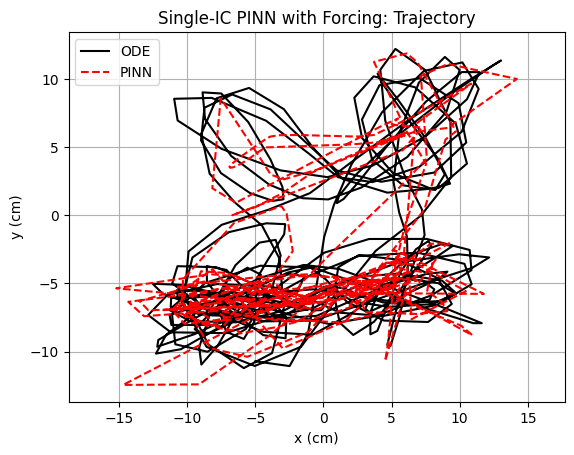

In [ ]:
# PINN for Ball Dynamics with Forcing Parameters (A, omega, phi)
# Trains on a single initial condition with full excitation terms

import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp

# Device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Parameters
params = {
    'alpha': 0.07, 'beta': 1.017, 'gamma': 15.103, 'delta': 0.00656,
    'H0': 12.065, 'g': 981, 'c': 0.0025, 'm': 0.1, 'inertia': 7/5,
    'A': 1.16, 'omega': 2 * np.pi * 1.25, 'phi': np.pi/6, 'theta': 0.0
}

# Dynamics
def ball_dynamics(t, y, p):
    x, y_, dx, dy = y
    alpha, beta, gamma, delta = p['alpha'], p['beta'], p['gamma'], p['delta']
    g, c, m, I = p['g'], p['c'], p['m'], p['inertia']
    A, w, phi, theta = p['A'], p['omega'], p['phi'], p['theta']
    eps = 1e-8

    Hx = 2*alpha*x - beta*x/np.sqrt(x**2 + gamma + eps) - delta*y_
    Hy = 2*alpha*y_ - beta*y_/np.sqrt(y_**2 + gamma + eps) - delta*x
    Hxx = 2*alpha - beta*gamma/(x**2 + gamma + eps)**1.5
    Hyy = 2*alpha - beta*gamma/(y_**2 + gamma + eps)**1.5
    Hxy = -delta

    ddx_base = A * w**2 * np.sin(w * t + phi) * np.cos(theta)
    ddy_base = A * w**2 * np.sin(w * t + phi) * np.sin(theta)

    M = I * np.array([[1+Hx**2, Hx*Hy], [Hx*Hy, 1+Hy**2]])
    nonlin_x = -I*(Hxx*(Hx*dx**2 + Hy*dx*dy) + Hxy*(Hx*dx*dy + Hy*dy**2))
    nonlin_y = -I*(Hyy*(Hy*dy**2 + Hx*dx*dy) + Hxy*(Hy*dx*dy + Hx*dx**2))
    damp_x = (c/m)*((1+Hx**2)*dx + Hx*Hy*dy)
    damp_y = (c/m)*((1+Hy**2)*dy + Hx*Hy*dx)

    F = np.array([
        -nonlin_x - damp_x - Hx*g - ddx_base,
        -nonlin_y - damp_y - Hy*g - ddy_base
    ])
    acc = np.linalg.solve(M, F)
    return [dx, dy, acc[0], acc[1]]

def generate_trajectory(p, y0, t_eval):
    sol = solve_ivp(lambda t, y: ball_dynamics(t, y, p), [t_eval[0], t_eval[-1]], y0, t_eval=t_eval)
    return sol.y.T

# Model
class SimplePINN(nn.Module):
    def __init__(self):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(5, 64), nn.Tanh(),
            nn.Linear(64, 64), nn.Tanh(),
            nn.Linear(64, 4)
        )

    def forward(self, t, ic):
        ic_repeated = ic.repeat(t.shape[0], 1)
        inp = torch.cat([t, ic_repeated], dim=1)
        return self.net(inp)

# Training
t_np = np.linspace(0, 40, 300)
y0 = [-6.55+0.1, -6.55+0.1, 0.0, 0.0]
y_np = generate_trajectory(params, y0, t_np)

t_tensor = torch.tensor(t_np, dtype=torch.float32).view(-1, 1).to(device)
y_tensor = torch.tensor(y_np, dtype=torch.float32).to(device)
ic_tensor = torch.tensor([y0], dtype=torch.float32).to(device)

model = SimplePINN().to(device)
optimizer = optim.Adam(model.parameters(), lr=1e-3)

# Training loop with IC enforcement
t0_tensor = torch.tensor([[0.0]], dtype=torch.float32).to(device)
for epoch in range(100000):
    optimizer.zero_grad()
    pred = model(t_tensor, ic_tensor)
    loss_data = torch.mean((pred - y_tensor)**2)
    pred_ic = model(t0_tensor, ic_tensor)
    loss_ic = torch.mean((pred_ic - ic_tensor)**2)
    loss = loss_data + 10.0 * loss_ic
    loss.backward()
    optimizer.step()
    if epoch % 400 == 0:
        print(f"Epoch {epoch}, Loss: {loss.item():.6f}, IC Loss: {loss_ic.item():.6f}")

# Predict and plot
t_test = torch.tensor(np.linspace(0, 40, 400), dtype=torch.float32).view(-1, 1).to(device)
with torch.no_grad():
    pred = model(t_test, ic_tensor).cpu().numpy()

true = generate_trajectory(params, y0, np.linspace(0, 40, 400))

plt.plot(true[:, 0], true[:, 1], 'k-', label='ODE')
plt.plot(pred[:, 0], pred[:, 1], 'r--', label='PINN')
plt.axis('equal')
plt.xlabel("x (cm)")
plt.ylabel("y (cm)")
plt.title("Single-IC PINN with Forcing: Trajectory")
plt.legend()
plt.grid(True)
plt.show()
